In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,  Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import quandl
from fredapi import Fred
import statsmodels.api as sm



pd.set_option("display.max_rows",200)
sns.set(rc={'figure.figsize':(16,10)})
fred_key = "df4910b2cad947d95cf6ab16ba11d74d"
fred = Fred(api_key = fred_key)
quandl.ApiConfig.api_key = 'Qq5R29Xiqp2yUbb9dzNq'


In [2]:
def plot(prediction,target,grey=None,start=None,end=None):
    
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # else:
    #     ylim = (df.min(),df.max())
    

    if not isinstance(prediction,pd.DataFrame):
        Results=pd.DataFrame(prediction,index=target.index)
        Results.plot(ax=ax,legend=True)
        ylim = (Results.min().min(),Results.max().max())
    else:
        prediction.plot(ax=ax,legend=True)
        ylim = (0,1)
    ax.fill_between(target.index, 0, ylim[1]+1e-2, target,facecolor='k', alpha=0.1)
    if not isinstance(prediction,pd.DataFrame):
        legend_list=["Prediction", "NBER recession indicator"]
    else:
        legend_list=["Prediction",'lower','upper', "NBER recession indicator"]
    # if '2022-02-24' in target.index:
    #     legend_list+=['Russian invasion of Ukraine']
    #     ax.axvline(x='2022-02-24', color='r')
    ax.legend(legend_list)
        
    return fig,ax

In [3]:
fixed_data=0

In [4]:
MacroCode=pd.read_csv(r'Data\Macro Variables.csv')
MacroCode.replace({'Average HOUST':'HOUST','S&P 500':'SP500'},inplace=True)

errors=[]
indicators={}
freq={}
for code in MacroCode['Variable']:
    if not ('S&P' in code):
        try:
            col=fred.get_series(code).to_frame(code).squeeze()
            if code == 'CPFF':
                indicators[code]=(col) #.resample('MS').last()
            elif code == "ICSA":
                indicators[code]=(col) #.resample('MS').sum()
            elif code == "SP500":
                indicators[code]=(col) #.resample('MS').first()
            else:
                indicators[code]=(col) # .resample('M').interpolate()
        except ValueError:
            errors.append(code)
indicators['S&P: indust']=(yf.download('^SP500-20')['Close'].to_frame('S&P: indust').squeeze()) # .resample("MS").last()
indicators['S&P div yield']=(quandl.get("MULTPL/SP500_DIV_YIELD_MONTH").squeeze().to_frame('S&P div yield').squeeze()) # .resample("MS").last()
indicators['S&P PE ratio']=(quandl.get("MULTPL/SP500_PE_RATIO_MONTH").squeeze().to_frame('S&P PE ratio').squeeze()) # .resample("MS").first()


[*********************100%***********************]  1 of 1 completed


In [5]:
for key in indicators:
    print(key,pd.infer_freq(indicators[key].index))

RPI MS
W875RX1 MS
DPCERA3M086SBEA MS
CMRMTSPL MS
RSXFS MS
INDPRO MS
IPFPNSS MS
IPFINAL MS
IPCONGD MS
IPDCONGD MS
IPNCONGD MS
IPBUSEQ MS
IPMAT MS
IPDMAT MS
IPNMAT MS
IPMANSICS MS
IPB51222S MS
IPFUELS MS
CUMFNS MS
CLF16OV MS
CE16OV MS
UNRATE MS
UEMPMEAN MS
UEMPLT5 MS
UEMP5TO14 MS
UEMP15OV MS
UEMP15T26 MS
UEMP27OV MS
ICSA W-SAT
PAYEMS MS
USGOOD MS
CES1021000001 MS
USCONS MS
MANEMP MS
DMANEMP MS
NDMANEMP MS
SRVPRD MS
USTPU MS
USWTRADE MS
USTRADE MS
USFIRE MS
USGOVT MS
CES0600000007 MS
AWOTMAN MS
AWHMAN MS
HOUST MS
HOUSTNE MS
HOUSTMW MS
HOUSTS MS
HOUSTW MS
PERMIT MS
PERMITNE MS
PERMITMW MS
PERMITS MS
PERMITW MS
ACOGNO MS
DGORDER MS
NEWORDER MS
AMDMUO MS
BUSINV MS
ISRATIO MS
M1SL MS
M2SL MS
M2REAL MS
AMBSL MS
TOTRESNS MS
NONBORRES MS
BUSLOANS MS
REALLN MS
NONREVSL MS
TOTALSL MS
SP500 B
FEDFUNDS MS
TB3MS MS
TB6MS MS
GS1 MS
GS5 MS
GS10 MS
AAA MS
BAA MS
CPFF B
TB3SMFFM MS
TB6SMFFM MS
T1YFFM MS
T5YFFM MS
T10YFFM MS
AAAFFM MS
BAAFFM MS
TWEXMMTH MS
EXSZUS MS
EXJPUS MS
EXUSUK MS
EXCAUS MS
WPSFD4920

In [6]:
if len(errors)>0:
    raise Exception("Erorrs found")
data=pd.concat(indicators,axis=1).copy() #.fillna(method='ffill') #.loc["1971":].dropna(how='all').fillna(method='ffill')
# data.to_csv('Data/HistoricalVariables.csv')
# print(data.shape)
# data.isna().sum().sort_values()/data.shape[0]

In [7]:
data=data.resample('D').last().fillna(method='ffill')

In [8]:
def deltaX(data):
    return data.diff()

def delta2X(data):
    return data-2*data.shift(1)+data.shift(2)

def logdata(data):
    return np.log(data)

def difflog(data):
    return np.log(data).diff()

def difflog2(data):
    return np.log(data)-2*np.log(data.shift(1))+np.log(data.shift(2))

def diffpercent(data):
    return (data/data.shift() - 1) - (data.shift()/data.shift(2) - 1)



transformation={1:(lambda x: x),
                2:deltaX,
                3:delta2X,
                4:logdata,
                5:difflog,
                6:difflog2,
                7:diffpercent,
                }

df_transformed=pd.DataFrame()

for column in data.columns:
    type=MacroCode[MacroCode['Variable'] == column]['Transformation'].iloc[0]
    df_transformed[column]=transformation[type](data[column])
    df_transformed=df_transformed.copy()

In [9]:
test=data.interpolate().dropna(thresh=110).copy()

In [10]:
recessions =  DataReader('USRECDM', 'fred', start='1800')
test['recessions']=recessions

In [11]:

# Separate the independent variables (X) and the dependent variable (y)
X = test.drop(['recessions'],axis=1).fillna(0)  # Drop the target variable from the independent variables
y = test['recessions'].fillna(0)  # Target variable

# Add a constant column to the independent variables
X = sm.add_constant(X)

# Create and fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression analysis
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             recessions   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     634.2
Date:                Sun, 28 May 2023   Prob (F-statistic):               0.00
Time:                        00:57:49   Log-Likelihood:                 9839.7
No. Observations:               19144   AIC:                        -1.944e+04
Df Residuals:                   19024   BIC:                        -1.850e+04
Df Model:                         119                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1820      0.597     

In [12]:
# df=yf.download("GE")
# df.head()
n_lookback=30
n_forecast=1

# df=pd.read_csv('Data/Transformed HistoricalVariables.csv',index_col=0,parse_dates=True)
df=df_transformed.loc['1971':].copy()
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES2000000008,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.014213,0.011976,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.0,0.031962
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.014213,-0.011976,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.0,0.000000
1971-01-03,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000
1971-01-04,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000
1971-01-05,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000


In [13]:

recessions =  DataReader('USRECDM', 'fred', start='1800')
# df[f'in a recession']=recessions
df['target'] = recessions.shift(-250)

df.fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1971':] #.resample('MS').last()
print(df.shape)
df.head()

(19144, 125)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,target
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.011976,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.0,0.031962,0.0
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.011976,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.0,0.000000,0.0
1971-01-03,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0
1971-01-04,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0
1971-01-05,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0


In [14]:
df.CPFF.dropna()

1997-01-02   -0.44
1997-01-03    0.18
1997-01-04    0.18
1997-01-05    0.18
1997-01-06    0.08
              ... 
2023-05-27    0.15
2023-05-28    0.15
2023-05-29    0.15
2023-05-30    0.15
2023-05-31    0.15
Freq: D, Name: CPFF, Length: 9646, dtype: float64

<Axes: >

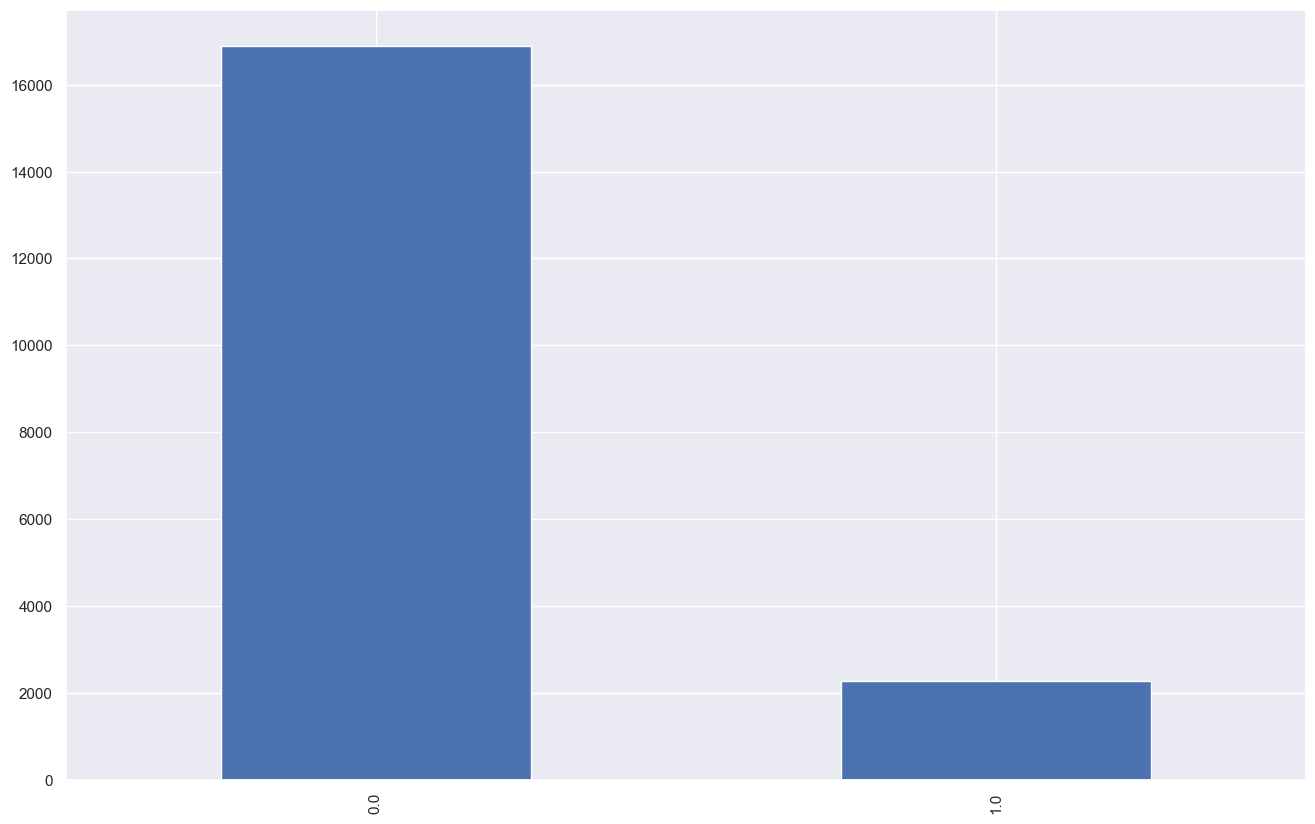

In [15]:
df.target.value_counts().plot.bar()

## Preprocessing


In [16]:
df_for_training=df[:"1999"]
df_for_validating=df["2000":"2003"]
df_for_testing=df["2004":]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_validating shape: ',df_for_validating.shape)
print('df_for_testing shape: ',df_for_testing.shape)


df_for_training shape:  (10592, 125)
df_for_validating shape:  (1461, 125)
df_for_testing shape:  (7091, 125)


# without recessions 

# GradientBoostingClassifier

In [17]:
df_for_training

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CES3000000008,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,target
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.011976,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.00,0.031962,0.0
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.011976,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.00,0.000000,0.0
1971-01-03,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.00,0.000000,0.0
1971-01-04,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.00,0.000000,0.0
1971-01-05,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.00,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-27,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.010887,0.00,0.000000,0.0
1999-12-28,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.002362,0.00,0.000000,0.0
1999-12-29,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.001768,0.00,0.000000,0.0
1999-12-30,0.000000,0.0000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,-0.000221,0.00,0.000000,0.0


## Logit

In [18]:
# # loading the training dataset 
# # Xtrain=df_for_training.drop(["target"],axis=1).fillna(0)
# Xtrain=data.loc[df_for_training.index].fillna(0)
# ytrain=(df_for_training['target']+1)/2
   
# # building the model and fitting the data
# log_reg = sm.Logit(ytrain, Xtrain).fit()

## CNN-LSTM

In [19]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)

In [20]:

# Scalling

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
df_for_validating_scaled=scaler.transform(df_for_validating.fillna(0))
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))

print()
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
validX,validY=createXY(df_for_validating_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
trainX.shape,validX.shape,testX.shape

((10562, 30, 124), (1431, 30, 124), (7061, 30, 124))

In [21]:
def CustomLoss(labels, pred,w=0.2): 
    logits=tf.math.log(pred/(1-pred))
    return tf.nn.weighted_cross_entropy_with_logits(labels, logits, w)

In [22]:
from tensorflow.keras.layers import LSTM,  Dense, Dropout, Conv1D, MaxPool1D,Flatten,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

PT_path='Model/CNN2-LSTM-test'
f1 = EarlyStopping(monitor='recall', mode='max', verbose=1, patience=30)
f2 = ModelCheckpoint(filepath=PT_path, monitor='val_recall', mode='max', verbose=0, save_best_only=True)



In [23]:
def model_builder(hp):
    # Choose an optimal value between 32-512
    hp_units_CNN1 = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_units_CNN2 = hp.Int('units', min_value=32, max_value=512, step=32)


    model = Sequential()
    model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]),))
    model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu'))
    model.add(MaxPool1D(1))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(RepeatVector(1))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense((n_forecast)
            ,activation='sigmoid'
            ))
    # fit the model
    model.compile(optimizer='adam',
            metrics=['Recall','Precision',"AUC"],
            loss=CustomLoss
            # loss='BinaryCrossentropy'
            )

    return model

In [24]:
trainY.shape

(10562, 1)

In [25]:
# model = Sequential()
# model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]),))
# model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu'))
# # model.add(Conv1D(filters=32,kernel_size=(3,),activation='relu'))
# model.add(MaxPool1D(1))
# model.add(Dropout(0.1))
# model.add(Flatten())
# model.add(RepeatVector(1))
# model.add(LSTM(100, return_sequences=False))
# model.add(Dense((n_forecast)
#             ,activation='sigmoid'
#             ))


model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]),),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPool1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    RepeatVector(n_forecast),
    LSTM(100, return_sequences=False),
    Dense(units=n_forecast, activation='sigmoid')
])




# fit the model
model.compile(optimizer='adam',
              metrics=['Recall', 'Precision', "AUC", "mse"],
              loss=CustomLoss
              # loss='BinaryCrossentropy'
              )

model.summary()
# fit the model
history = model.fit(trainX, trainY, epochs=150, batch_size=32,
                    # validation_split=0.1,
                    validation_data=(validX, validY),
                    verbose=1,
                    callbacks=[
                        #  f1,
                        f2
                    ]
                    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 32)            11936     
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 32)            0         
                                                                 
 flatten (Flatten)           (None, 416)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 416)           0         
 )                                                      

KeyboardInterrupt: 

In [26]:
import keras_tuner as kt
from tensorflow.keras.regularizers import l1, l2,l1_l2

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('CNN_1_filters', min_value=16, max_value=256, step=64),
                     kernel_size=hp.Choice('CNN_1_kernel_size', values=[k for k in range(10) if k%2==1]),
                     activation='relu',
                     input_shape=(trainX.shape[1], trainX.shape[2]),
                     kernel_regularizer=l1(hp.Choice('CNN1_l1_regularization', values=[0.0, 1e-4, 1e-3, 1e-2]))))
    model.add(Conv1D(filters=hp.Int('CNN_2_filters', min_value=16, max_value=256, step=64),
                     kernel_size=hp.Choice('CNN_2_kernel_size', values=[k for k in range(10) if k%2==1]),
                     activation='relu',
                     kernel_regularizer=l2(hp.Choice('CNN1_l2_regularization', values=[0.0, 1e-4, 1e-3, 1e-2]))))
    model.add(MaxPool1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(RepeatVector(n_forecast))
    model.add(LSTM(units=hp.Int('LSTM_units', min_value=32, max_value=256, step=64),
                   return_sequences=hp.Boolean("return_sequences",),
                   kernel_regularizer=l1_l2(hp.Choice('LSTM_l1_l2_regularization', values=[0.0, 1e-4, 1e-3, 1e-2]))))
    model.add(Dense(units=n_forecast, activation='sigmoid',
                    kernel_regularizer=l2(hp.Choice('dense_L2_regularization', values=[0.0, 1e-4, 1e-3, 1e-2]))))
    
    model.compile(optimizer='adam',
                  metrics=['Recall', 'Precision', 'AUC', 'mse'],
                  loss=CustomLoss)
    
    return model


In [28]:


# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_recall", direction="max"),
    max_trials=300,
    executions_per_trial=10,
    overwrite=True,
    project_name='model_tuning',
    directory="keras_tuner_dir",
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
                    monitor='val_loss',
                    patience=10,
                    restore_best_weights=True,
                    
                )

# Perform the hyperparameter search
tuner.search(trainX, trainY, epochs=600,batch_size=3000 ,validation_data=(validX, validY),callbacks=[early_stopping],verbose=1)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
80                |80                |CNN_1_filters
9                 |9                 |CNN_1_kernel_size
0.001             |0.001             |l1_regularization
80                |80                |CNN_2_filters
7                 |7                 |CNN_2_kernel_size
0                 |0                 |l2_regularization
32                |32                |LSTM_units
True              |True              |return_sequences
0.01              |0.01              |l1_l2_regularization
0.0001            |0.0001            |dense_regularization

Epoch 1/600
2/2 [==============================] - 9s 2s/step - loss: 41.0765 - recall: 0.0663 - precision: 0.1101 - auc: 0.4805 - mse: 0.2222 - val_loss: 39.1561 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.8696 - val_mse: 0.1501
Epoch 2/600
2/2 [==============================] - 3s 546ms/step - loss: 39.0388 - recall: 0.0000e+00 - precision: 0.

KeyboardInterrupt: 

In [38]:

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Compile the best model
best_model.compile(optimizer='adam',
                   metrics=['Recall', 'Precision', 'AUC', 'mse'],
                   loss=CustomLoss)


In [39]:
best_hyperparameters

In [40]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show();
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.legend()
plt.show();
plt.plot(history.history['recall'], label='Training recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.legend()

NameError: name 'history' is not defined

In [41]:
best_model

In [43]:
# best_model=tf.keras.models.clone_model(model)
# best_model.load_weights(PT_path)

In [44]:
def align_data(pred, origin):
    aligned = pd.DataFrame(columns=[f'pred{i}' for i in range(n_forecast)], index=pd.date_range(
    start=origin.index[0], freq='D', periods=pred.shape[0]+n_forecast-1))
    for i in range(len(pred)):
        col=i % n_forecast
        try:
            aligned.iloc[i:i+n_forecast,col]=pred[i]
        except IndexError:
            break
    CI=aligned.std(axis=1)* 1.96 / np.sqrt(aligned.shape[1])
    mean=aligned.mean(axis=1)
    aligned=pd.concat([mean,mean-CI,mean+CI],keys=['m','lc',"uc"],axis=1)
    return aligned

In [45]:
prediction_train=best_model.predict(trainX)
prediction_valid=best_model.predict(validX)
prediction_test=best_model.predict(testX)


221/221 [==============================] - 3s 13ms/step


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

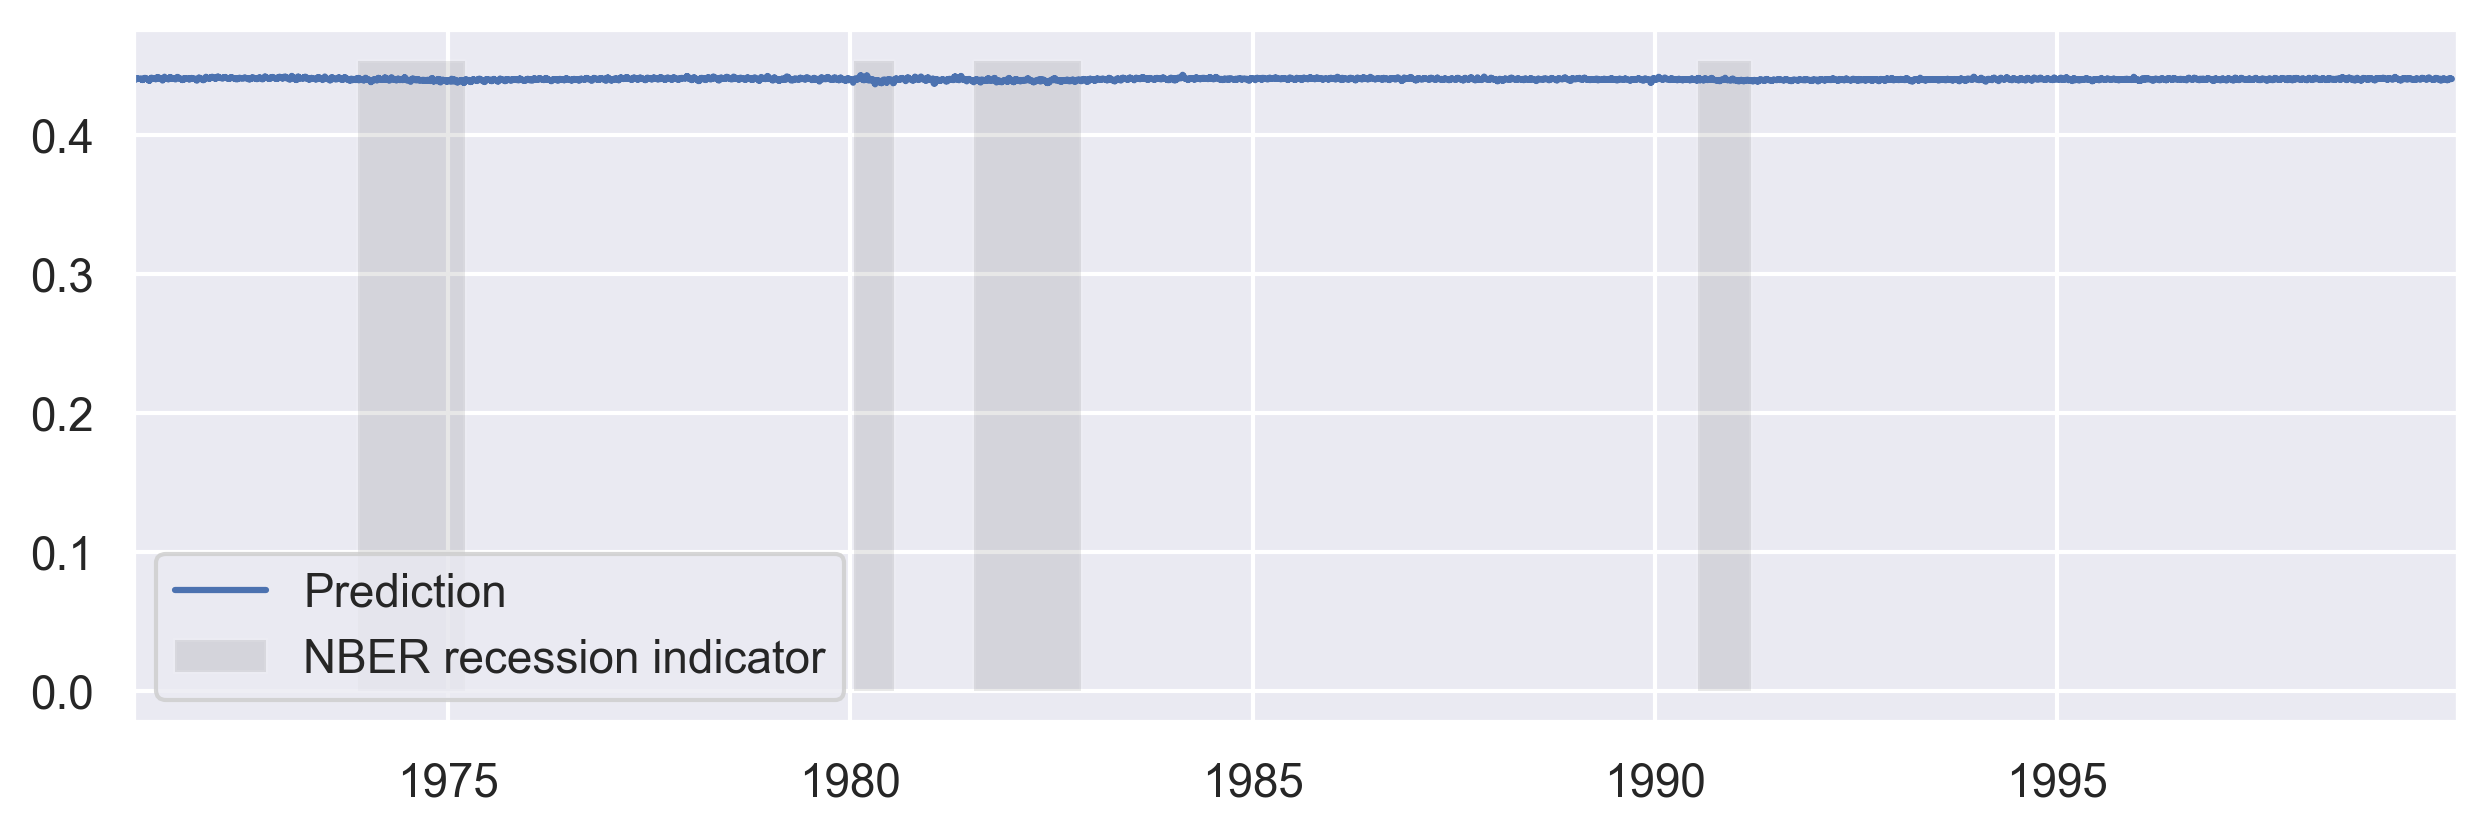

In [46]:
min_length = min(len(df_for_training), len(prediction_train))
trainResults= pd.DataFrame(index=df_for_training.iloc[-min_length:,-1].index)

trainResults['Actual']=recessions
trainResults['Pred']=align_data(prediction_train, df_for_training)['m']
plot(trainResults['Pred'],trainResults["Actual"])

(<Figure size 3000x900 with 1 Axes>, <Axes: >)

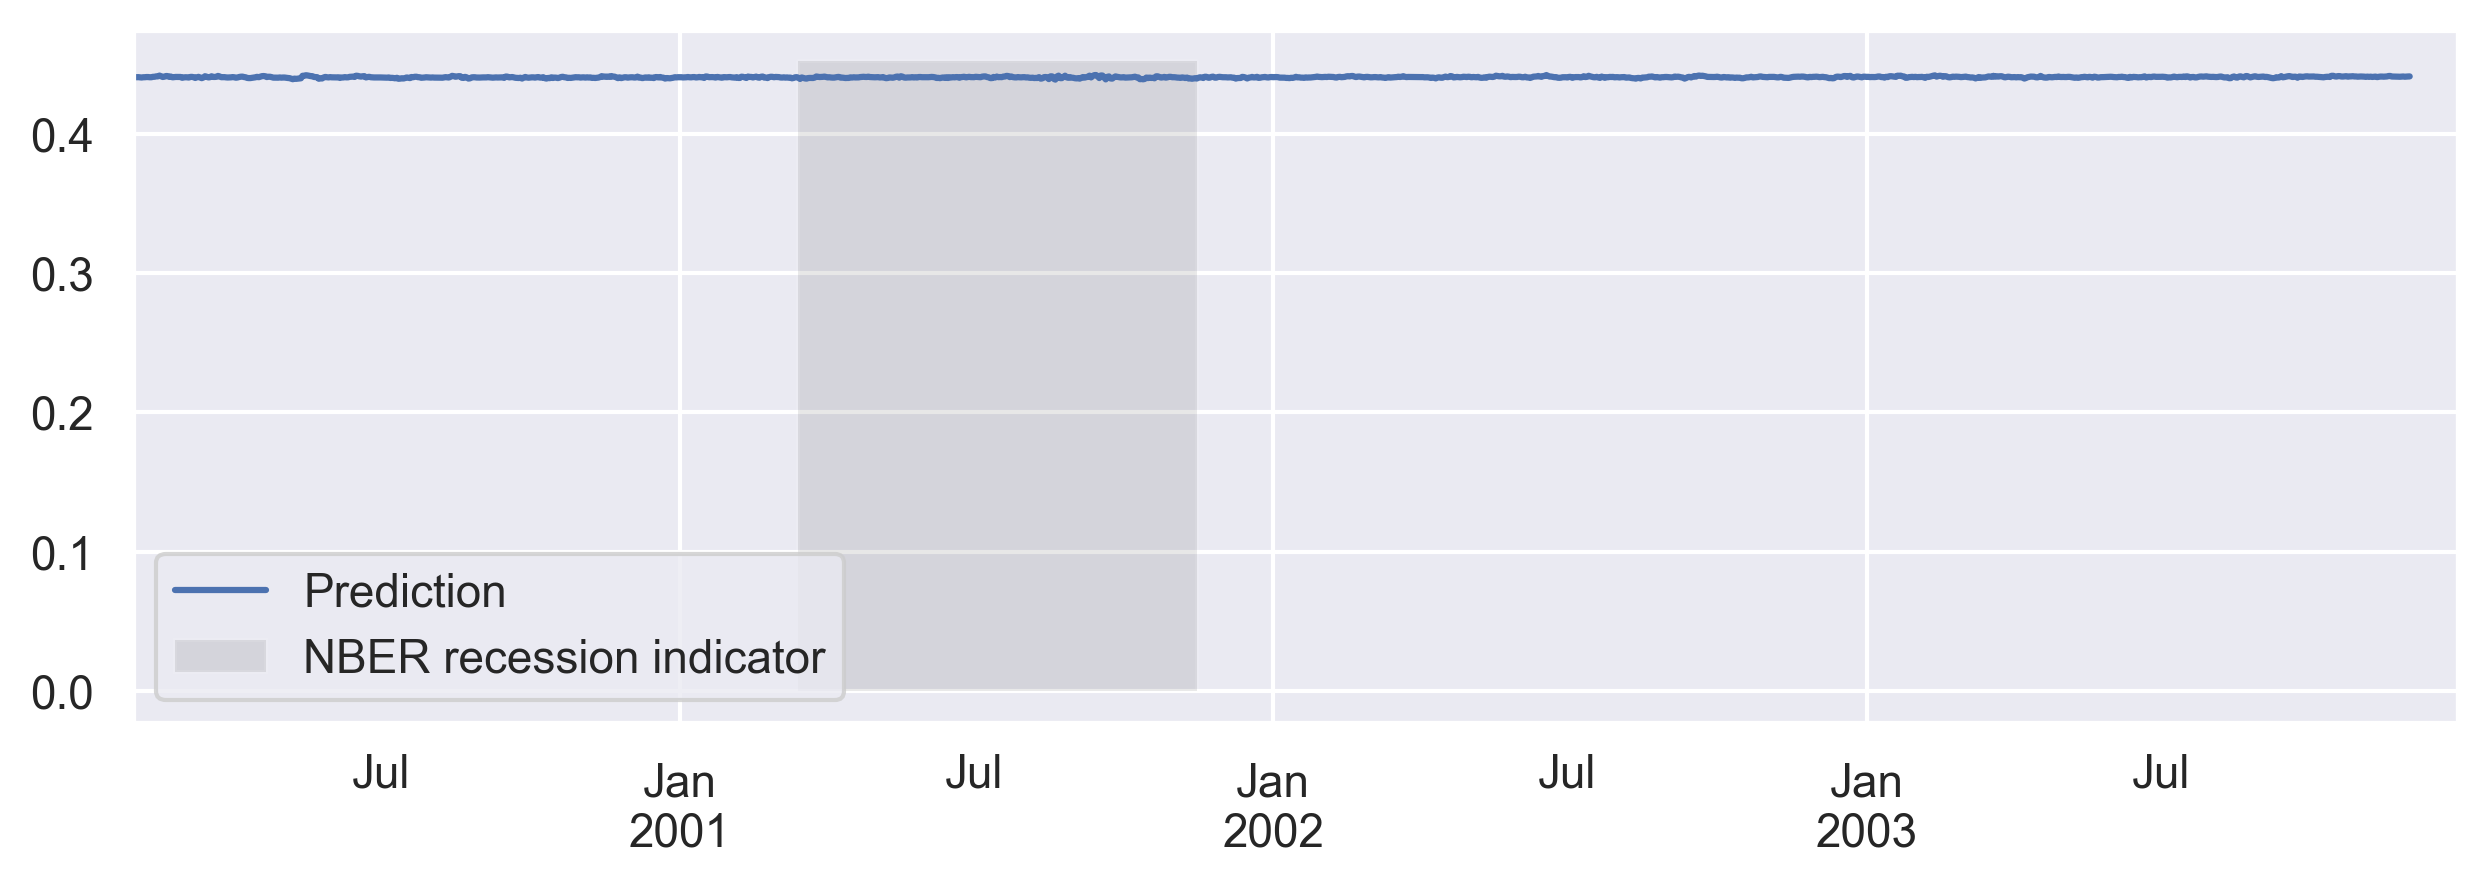

In [47]:
min_length = min(len(df_for_validating), len(prediction_valid))
validResults= pd.DataFrame(index=df_for_validating.iloc[-min_length:,-1].index)

validResults['Actual']=recessions
validResults['Pred']=align_data(prediction_valid[-min_length:], df_for_validating)['m']
plot(validResults['Pred'],validResults['Actual'])

(<Figure size 3000x900 with 1 Axes>, <Axes: >)

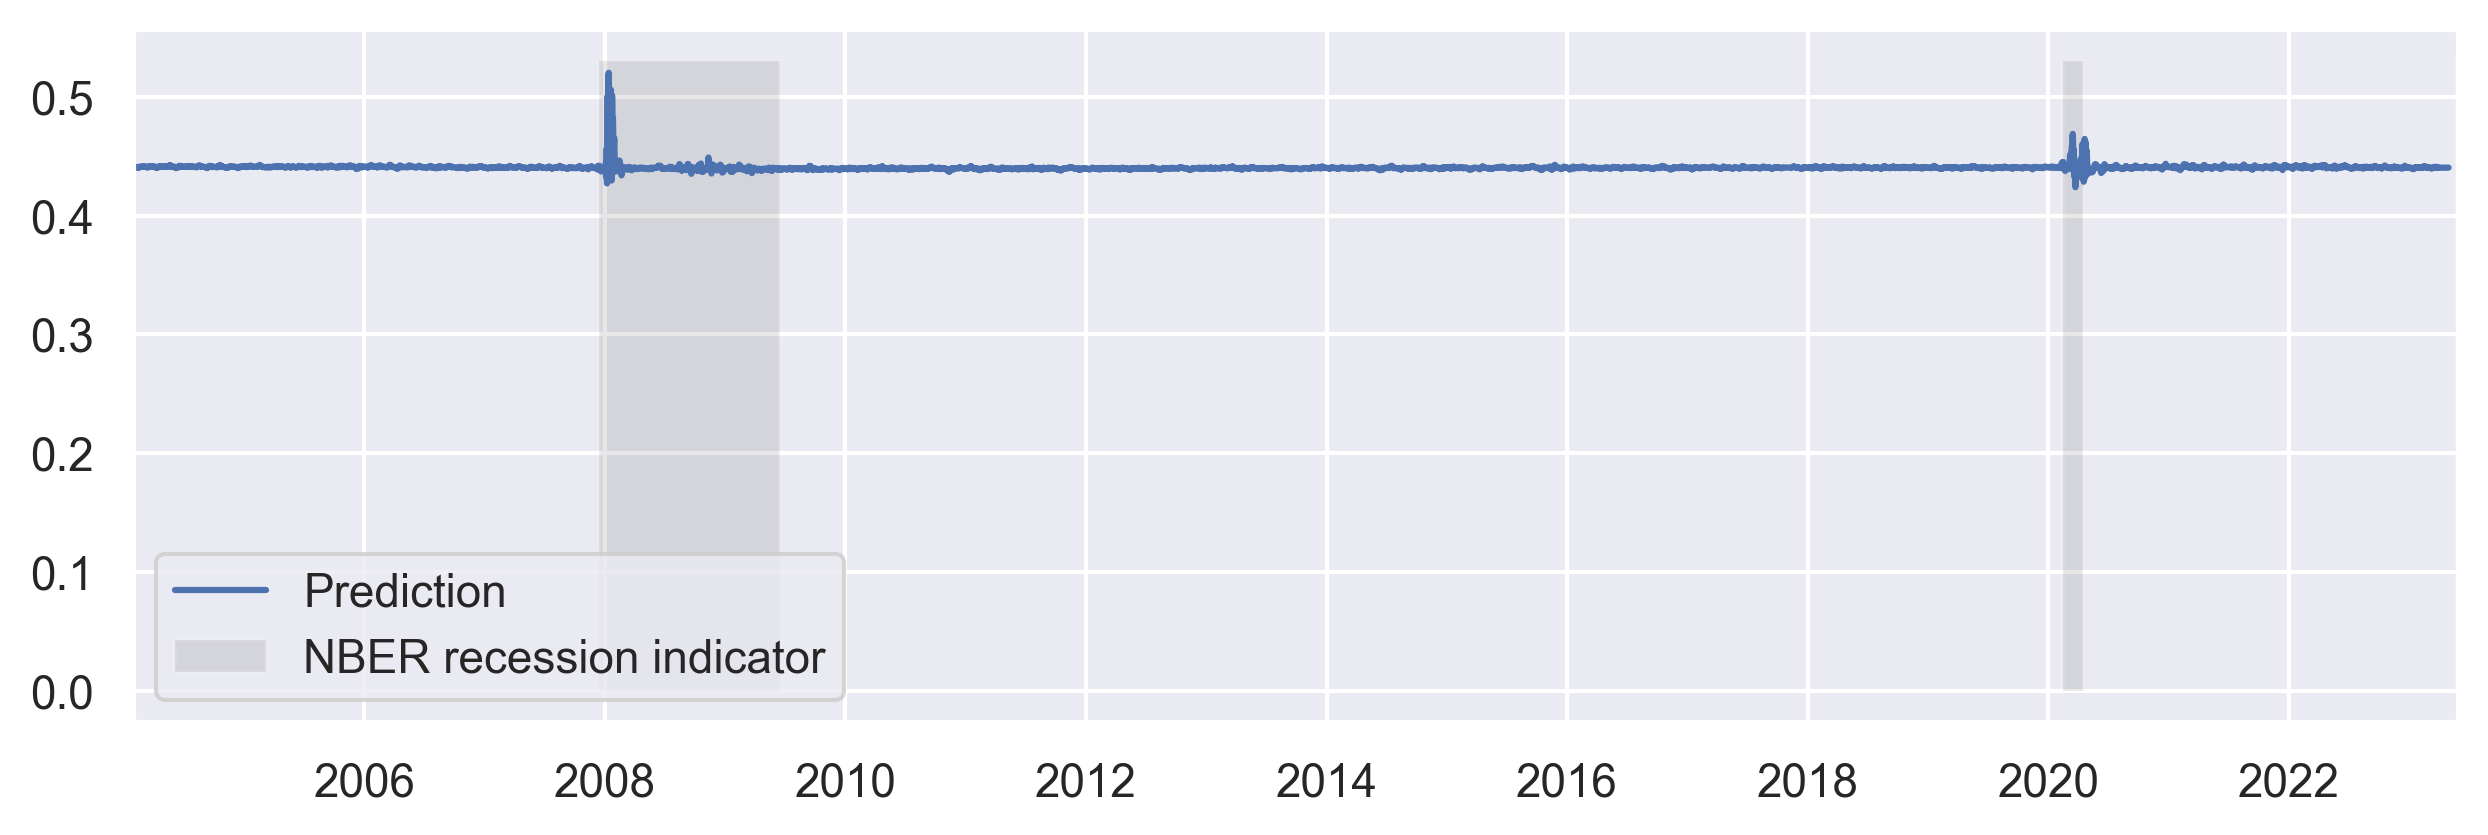

In [48]:
min_length = min(len(df_for_testing), len(prediction_test))
testResults= pd.DataFrame(index=df_for_testing.iloc[-min_length:,-1].index)

testResults['Actual']=recessions
testResults['Pred']=align_data(prediction_test[-min_length:], df_for_testing)['m']
plot(testResults['Pred'],testResults['Actual'])